# Preparation
In this section the google drive is mounted on colab server to use GPU. GPU availablity is checked and registered.

In [1]:
################################################################################
#-----------------------     Google Drive Mount     ---------------------------#
################################################################################

from google.colab import drive
import sys, os

# Mounts google drive on Colab server and changes to working directory pth.
# Requires identity authentication.

pth = 'My Drive/Projects/Advertima/'
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/'+pth)
os.chdir('/content/gdrive/'+pth)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [2]:
################################################################################
#-----------------------         CUDA Device        ---------------------------#
################################################################################
import torch

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    device = 'cpu'
    print('CUDA is not available.  Training on CPU ...')
else:
    device = 'gpu'
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Data import and preprocessing
The fasion MNIST data are loaded and two loaders are prepared: augmented and not augmented. For augmentation, we consider random rotation and horizontal flip. Many other augmentations are tested, but only these are considered to be influential with our models.

In [0]:
################################################################################
#-----------------------   Data  Transformations    ---------------------------#
################################################################################
import torchvision.transforms as transforms

# Transformations with augmentations
augmented_transform = transforms.Compose([
                                          transforms.RandomRotation(5),
                                          transforms.RandomHorizontalFlip(),        
                                          transforms.ToTensor(),
                                          ])
# Transformations without augmentations
not_augmented_transform = transforms.Compose([
                                              transforms.ToTensor(),
                                              ])

In [0]:
################################################################################
#-------------------------        Data  Sets        ---------------------------#
################################################################################
from torchvision import datasets

## Loads data from 'data' directory and process and prepares them in datasets

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 32
# percentage of training set to use as validation
valid_size = 0.2

# choose the training and test datasets (train sets both augmented and not)
train_data_aug  = datasets.FashionMNIST(root='data', train=True, download=True, 
                                        transform=augmented_transform)
train_data_naug = datasets.FashionMNIST(root='data', train=True, download=True, 
                                        transform=not_augmented_transform)

test_data = datasets.FashionMNIST(root='data', train=False, download=True, 
                                        transform=not_augmented_transform)

## Training, vailidation and testing data 
We split the training data to 20% for training and 80% for validation set. The validation data set is used for validation of fine tuning through training.

In [0]:
################################################################################
#------------------    Training/Validation/Test Loader     --------------------#
################################################################################
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader as dl

# obtain training indices that will be used for validation
num_train = len(train_data_aug)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader_aug  = dl(train_data_aug, batch_size=batch_size,
                       sampler=train_sampler, num_workers=num_workers)
valid_loader_aug  = dl(train_data_aug, batch_size=batch_size, 
                       sampler=valid_sampler, num_workers=num_workers)

train_loader_naug = dl(train_data_naug, batch_size=batch_size,
                       sampler=train_sampler, num_workers=num_workers)
valid_loader_naug = dl(train_data_naug, batch_size=batch_size, 
                       sampler=valid_sampler, num_workers=num_workers)

test_loader = dl(test_data, batch_size=batch_size, num_workers=num_workers)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Augmented data set:


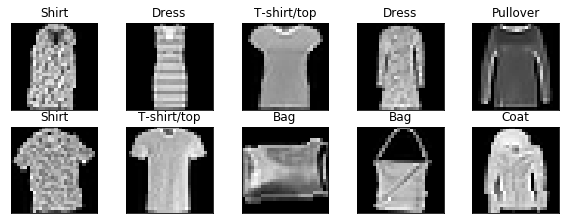

In [6]:
################################################################################
#------------------           Data Visualization           --------------------#
################################################################################
%matplotlib inline
import utils
from utils import vis_data
import torch.nn as nn

print("Augmented data set:")
vis_data(train_loader_aug, classes)

Data set without augmentation:


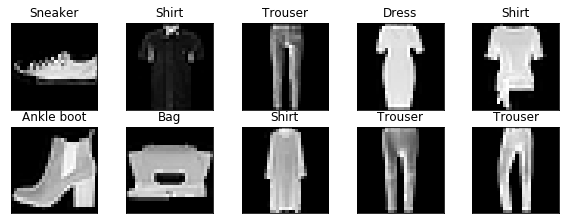

In [7]:
print("Data set without augmentation:")
vis_data(train_loader_naug, classes)


# Pepare models
We have three models:
- **Model1**: 3 conv layes and 2 fully connected layers, no augmentation
- **Model2**: 3 conv layes and 2 fully connected layers with augmentation
- **Model3**: 3 conv layes and 2 fully connected layers and 6 resnet layers with augmentaion

Each conv layer is followed by batch normalization. Two max pool layer with stride 2 are used between conv layers. Each resnet block contains two conv layers with the same size of in and out channel numbers. We have added a dropout before the second conv layer in each resnet block. The class and functions are explained here and are included in the utils.py file.

## Residual Block Class

ResNet blocks rely on connecting the output of one layer with the input of an earlier layer. The motivation for this structure is as follows: very deep neural networks can be difficult to train. Deeper networks are more likely to have vanishing or exploding gradients and, therefore, have trouble reaching convergence; batch normalization helps with this a bit. However, during training, we often see that deep networks respond with a kind of training degradation. Essentially, the training accuracy stops improving and gets saturated at some point during training. In the worst cases, deep models would see their training accuracy actually worsen over time!

<img src='./resnet_50.png' width=90%/>

One solution to this problem is to use **Resnet blocks** that allow us to learn so-called *residual functions* as they are applied to layer inputs. The solution here is based on the proposed architecture in the paper, [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf) by Kaiming He et. al, and the images here are from that paper.

<img src='./resnet_block.png' width=40%/>

## Residual Functions

Usually, when we create a deep learning model, the model (several layers with activations applied) is responsible for learning a mapping, `M`, from an input `x` to an output `y`.
>`M(x) = y` (Equation 1)

Instead of learning a direct mapping from `x` to `y`, we can instead define a **residual function**
> `F(x) = M(x) - x`

This looks at the difference between a mapping applied to x and the original input, x. `F(x)` is, typically, two convolutional layers + normalization layer and a ReLu in between. These convolutional layers should have the same number of inputs as outputs. This mapping can then be written as the following; a function of the residual function and the input x. The addition step creates a kind of loop that connects the input x to the output, y:
>`M(x) = F(x) + x` (Equation 2) or

>`y = F(x) + x` (Equation 3)

### Optimizing a Residual Function

The idea is that it is easier to optimize this residual function `F(x)` than it is to optimize the original mapping `M(x)`. Consider an example; what if we want `y = x`?

From our first, direct mapping equation, **Equation 1**, we could set `M(x) = x` but it is easier to solve the residual equation `F(x) = 0`, which, when plugged in to **Equation 3**, yields `y = x`.


## Defining the `ResidualBlock` Class

To define the `ResidualBlock` class, we'll define residual functions (a series of layers), apply them to an input x and add them to that same input. This is defined just like any other neural network, with an `__init__` function and the addition step in the `forward` function. 

In our case, you'll want to define the residual block as:
* Two convolutional layers with the same size input and output
* Batch normalization applied to the outputs of the convolutional layers
* A ReLu function on the output of the *first* convolutional layer

Then, in the `forward` function, add the input x to this residual block. Feel free to use the helper `conv` function from above to create this block.

In [0]:
################################################################################
#------------------            Initialize Models           --------------------#
################################################################################
from utils import minivgg, miniresnet

# create three models
model1 = minivgg()
model2 = minivgg()
model3 = miniresnet()

# move tensors to GPU if CUDA is available
if train_on_gpu:
    model1.cuda()
    model2.cuda()
    model3.cuda()    

## Loss function and optimizer
We use cross entropy loss function for all models. After trying SGD and Adam optimizers, we considered Adam optimizer for the training.

In [0]:
################################################################################
#------------------  Loss Function & Optimizer & Hyperparameters --------------#
################################################################################
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
lr = 0.001
alfa = 0.9
beta = 0.999

opt1 = optim.Adam(model1.parameters(), lr,[alfa, beta])
opt2 = optim.Adam(model2.parameters(), lr,[alfa, beta])
opt3 = optim.Adam(model3.parameters(), lr,[alfa, beta])

# number of epochs to train the model
n_epochs = 100

# Training
We train the three models for 100 epochs. The results show that the validation loss starts increasing after 10 to 30+ steps and the model over fits after that. The results are saved only when the validation loss is decreased. So, the last saved model is the best trained model.

In [17]:
from utils import train

train( n_epochs=n_epochs, model=model1, 
       train_loader=train_loader_naug, 
       valid_loader=valid_loader_naug,
       optimizer=opt1,
       criterion=criterion,
       model_name="minivgg_not_augmented",
       train_on_gpu=train_on_gpu)

Epoch: 1 Training Loss: 0.318651 	Validation Loss: 0.054962
Validation loss decreased (inf --> 0.054962).  Saving model ...
Epoch: 2 Training Loss: 0.226190 	Validation Loss: 0.047407
Validation loss decreased (0.054962 --> 0.047407).  Saving model ...
Epoch: 3 Training Loss: 0.202234 	Validation Loss: 0.045349
Validation loss decreased (0.047407 --> 0.045349).  Saving model ...
Epoch: 4 Training Loss: 0.180690 	Validation Loss: 0.041756
Validation loss decreased (0.045349 --> 0.041756).  Saving model ...
Epoch: 5 Training Loss: 0.169174 	Validation Loss: 0.043556
Epoch: 6 Training Loss: 0.159030 	Validation Loss: 0.043041
Epoch: 7 Training Loss: 0.146679 	Validation Loss: 0.041481
Validation loss decreased (0.041756 --> 0.041481).  Saving model ...
Epoch: 8 Training Loss: 0.134332 	Validation Loss: 0.041607
Epoch: 9 Training Loss: 0.128084 	Validation Loss: 0.041880
Epoch: 10 Training Loss: 0.126887 	Validation Loss: 0.039946
Validation loss decreased (0.041481 --> 0.039946).  Saving 

In [18]:
train( n_epochs=n_epochs, model=model2, 
       train_loader=train_loader_aug, 
       valid_loader=valid_loader_aug,
       optimizer=opt2,
       criterion=criterion,
       model_name="minivgg_augmented",
       train_on_gpu=train_on_gpu)

Epoch: 1 Training Loss: 0.361439 	Validation Loss: 0.070112
Validation loss decreased (inf --> 0.070112).  Saving model ...
Epoch: 2 Training Loss: 0.264140 	Validation Loss: 0.053513
Validation loss decreased (0.070112 --> 0.053513).  Saving model ...
Epoch: 3 Training Loss: 0.236300 	Validation Loss: 0.049818
Validation loss decreased (0.053513 --> 0.049818).  Saving model ...
Epoch: 4 Training Loss: 0.222882 	Validation Loss: 0.047098
Validation loss decreased (0.049818 --> 0.047098).  Saving model ...
Epoch: 5 Training Loss: 0.207748 	Validation Loss: 0.046548
Validation loss decreased (0.047098 --> 0.046548).  Saving model ...
Epoch: 6 Training Loss: 0.202418 	Validation Loss: 0.045085
Validation loss decreased (0.046548 --> 0.045085).  Saving model ...
Epoch: 7 Training Loss: 0.193849 	Validation Loss: 0.042669
Validation loss decreased (0.045085 --> 0.042669).  Saving model ...
Epoch: 8 Training Loss: 0.185008 	Validation Loss: 0.042767
Epoch: 9 Training Loss: 0.180266 	Validati

In [0]:
train( n_epochs=n_epochs, model=model3, 
       train_loader=train_loader_aug, 
       valid_loader=valid_loader_aug,
       optimizer=opt3,
       criterion=criterion,
       model_name="miniresnet_augmented",
       train_on_gpu=train_on_gpu)

Epoch: 1 Training Loss: 0.371679 	Validation Loss: 0.064303
Validation loss decreased (inf --> 0.064303).  Saving model ...
Epoch: 2 Training Loss: 0.265655 	Validation Loss: 0.052311
Validation loss decreased (0.064303 --> 0.052311).  Saving model ...
Epoch: 3 Training Loss: 0.239146 	Validation Loss: 0.050990
Validation loss decreased (0.052311 --> 0.050990).  Saving model ...
Epoch: 4 Training Loss: 0.221100 	Validation Loss: 0.045587
Validation loss decreased (0.050990 --> 0.045587).  Saving model ...
Epoch: 5 Training Loss: 0.209054 	Validation Loss: 0.047999
Epoch: 6 Training Loss: 0.201609 	Validation Loss: 0.042841
Validation loss decreased (0.045587 --> 0.042841).  Saving model ...
Epoch: 7 Training Loss: 0.190902 	Validation Loss: 0.047634
Epoch: 8 Training Loss: 0.183696 	Validation Loss: 0.041044
Validation loss decreased (0.042841 --> 0.041044).  Saving model ...
Epoch: 9 Training Loss: 0.177606 	Validation Loss: 0.040452
Validation loss decreased (0.041044 --> 0.040452). 

# Testin models

We use the best trained model for each of the models and check them against the test data set perpared before.
Based on these trainings, the following results are obtained:
- **Model1 92% accuracy**
- **Model2 93% accuracy**
- **Model4 94% accuracy**

In [10]:
model1.load_state_dict(torch.load('minivgg_not_augmented.pt'))
model2.load_state_dict(torch.load('minivgg_augmented.pt'))
model3.load_state_dict(torch.load('miniresnet_augmented.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [11]:
from utils import test_model

test_model(model=model1, 
           criterion=criterion,
           batch_size=batch_size,
           test_loader=test_loader, 
           train_on_gpu=train_on_gpu,
           classes=classes)

Test Loss: 2071.162587

Test Accuracy of T-shirt/top: 89% (897/1000)
Test Accuracy of Trouser: 98% (986/997)
Test Accuracy of Pullover: 90% (900/999)
Test Accuracy of Dress: 92% (927/999)
Test Accuracy of  Coat: 89% (898/999)
Test Accuracy of Sandal: 98% (979/997)
Test Accuracy of Shirt: 74% (749/999)
Test Accuracy of Sneaker: 96% (968/999)
Test Accuracy of   Bag: 99% (988/997)
Test Accuracy of Ankle boot: 97% (970/998)

Test Accuracy (Overall): 92% (9262/9984)


In [12]:
test_model(model=model2,
           criterion=criterion,
           batch_size=batch_size,
           test_loader=test_loader, 
           train_on_gpu=train_on_gpu,
           classes=classes)

Test Loss: 1958.172364

Test Accuracy of T-shirt/top: 87% (872/1000)
Test Accuracy of Trouser: 99% (989/997)
Test Accuracy of Pullover: 92% (927/999)
Test Accuracy of Dress: 94% (943/999)
Test Accuracy of  Coat: 90% (904/999)
Test Accuracy of Sandal: 99% (989/997)
Test Accuracy of Shirt: 79% (792/999)
Test Accuracy of Sneaker: 98% (987/999)
Test Accuracy of   Bag: 98% (984/997)
Test Accuracy of Ankle boot: 94% (945/998)

Test Accuracy (Overall): 93% (9332/9984)


In [13]:
test_model(model=model3, 
           criterion=criterion,
           batch_size=batch_size,
           test_loader=test_loader, 
           train_on_gpu=train_on_gpu,
           classes=classes)

Test Loss: 1741.073952

Test Accuracy of T-shirt/top: 90% (902/1000)
Test Accuracy of Trouser: 99% (988/997)
Test Accuracy of Pullover: 93% (935/999)
Test Accuracy of Dress: 96% (960/999)
Test Accuracy of  Coat: 90% (901/999)
Test Accuracy of Sandal: 98% (984/997)
Test Accuracy of Shirt: 78% (786/999)
Test Accuracy of Sneaker: 98% (983/999)
Test Accuracy of   Bag: 99% (988/997)
Test Accuracy of Ankle boot: 97% (972/998)

Test Accuracy (Overall): 94% (9399/9984)


# Visualizing results
The trained models' predictions on part of the test data set are visualized using TSNE from sklearn.

We can see that shirt class shows the most distributed in all models. This is observed in the low accuracy of shirt reported in the previous section.

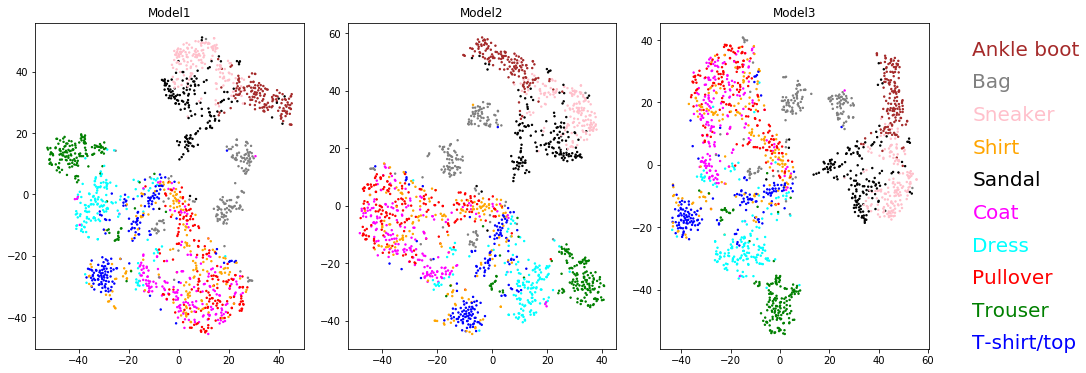

In [14]:
from utils import plot_tsne
plot_tsne(model1, model2, model3, test_loader, train_on_gpu, classes)